## Multi-Class Classification

For this exercise we'll use logistic regression to recognize hand-written digits (0 to 9).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image
%matplotlib inline
data = loadmat('/Users/natalychacon/Documents/Machine Learning/std coursera/machine-learning-ex/ex3/ex3data1.mat') 
#As ex3data1 is in Matlab native format loadmat had to be used.
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is 'unrolled' into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

In [2]:
#dimentions of the data
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

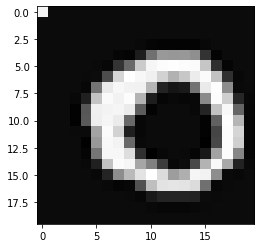

In [3]:
rows = data['X'].shape[0]
X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)
X1 = X[5]
X1 = X1[0:400]
X1 = np.array(X1)
X1 = X1.reshape(20,20)
fig, ax = plt.subplots()
ax.imshow(X1, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

### Vectorize Logistic Regression

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

In [5]:
def cost(theta,X,y,learning_rate):
    m = np.size(y,0)
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    sig = sigmoid(X * theta.T)
    j = 1/m * np.sum(np.multiply(-y,np.log(sig))-np.multiply((1-y),np.log(1-sig))) + (((learning_rate)/(2*m))*np.sum(np.power(theta[:,1:theta.shape[1]],2)))
    return j

In [6]:
def gradient(theta,X,y,learning_rate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = np.size(y,0)
    sig = sigmoid(X * theta.T)
    grad1 = 1/m *X.T*(sig-y) 
    grad2 = learning_rate/m * theta
    grad2[0,0]=0
    return grad1.T+grad2

In [7]:
theta_t = np.matrix('-2, -1, 1, 2')
X_t = np.insert(np.reshape(np.arange(1,16), (5,3), order='F')/10, 0, 1, axis=1)
y_t = np.matrix("1;0;1;0;1")
lambda_t = 3

In [8]:
gradient(theta_t,X_t,y_t,lambda_t)

matrix([[ 0.14656137, -0.54855841,  0.72472227,  1.39800296]])

In [9]:
cost(theta_t,X_t,y_t,lambda_t)

2.534819396109744

### One-vs-all

Now that we've defined our cost and gradient functions, it's time to build a classifier. For this task we've got 10 possible classes, and since logistic regression is only able to distiguish between 2 classes at a time, we need a strategy to deal with the multi-class scenario. In this exercise we're tasked with implementing a one-vs-all classification approach, where a label with k different classes results in k classifiers, each one deciding between "class i" and "not class i" (i.e. any class other than i). We're going to wrap the classifier training up in one function that computes the final weights for each of the 10 classifiers and returns the weights as a k X (n + 1) array, where n is the number of parameters.

In [29]:
from scipy.optimize import minimize
def one_vs_all(X,y,num_labels,learning_rate):
    m = X.shape[0] #Rows
    n = X.shape[1] #Parameters
    
    all_theta = np.zeros((num_labels, n + 1))
    
    #insert a column of ones for the intercept therm
    X = np.insert(X, 0, 1, axis=1)
   
   
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(n + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (m, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta
    

We are transforming y from  class label to a binary value for each classifier. Spicy minimize is used to minimize the cost function for each classifier.

In [30]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-2.38161327e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30425774e-03, -7.18023833e-10,  0.00000000e+00],
       [-3.18368854e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.45819726e-03, -5.08285164e-04,  0.00000000e+00],
       [-4.79819385e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.86238044e-05, -2.46864927e-07,  0.00000000e+00],
       ...,
       [-7.98669723e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.95615484e-05,  7.22105352e-06,  0.00000000e+00],
       [-4.57192130e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33570237e-03,  9.98944016e-05,  0.00000000e+00],
       [-5.40479660e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16598595e-04,  7.88728728e-06,  0.00000000e+00]])

We are going to used the trained classifiers to predict a label for each image.We're going to compute the class probability for each class, for each training instance (using vectorized code of course!) and assign the output class label as the class with the highest probability.

In [41]:
def predict_One_vs_all (X,all_theta):
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    m = X.shape[0] #Rows
    num_labels = np.size(theta_t,0)
    
    #insert a column of ones for the intercept therm
    X = np.insert(X, 0, 1, axis=1)
    
    # compute the class probability for each class on each training instance
    A = X * all_theta.T
    
    # create array of the index with the maximum probability
    A_argmax = np.argmax(A, axis=1)
    
    return A_argmax    

In [43]:
y_pred = predict_One_vs_all(data['X'], all_theta)
y_pred

matrix([[9],
        [9],
        [9],
        ...,
        [8],
        [8],
        [6]])